In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np
import string
import time
import string
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
#casedata = pd.read_csv('new_case_number.csv', usecols=[0,1], engine='python', header = 0)
casedata = pd.read_csv('new_case_number.csv', usecols=[0,1], engine='python', header = 0)
stock_price = pd.read_csv('stock_price.csv', engine='python', header = 0)
#stock_sector = pd.read_csv('constituents_csv.csv', engine='python', header = 0)
stock_sector = pd.read_csv('sector_info.csv', engine='python', header = 0)
stock_sector = stock_sector.rename(columns = {'GICS Sector': 'Sector'})
casedata = casedata.rename(columns = {'date': 'Date', 'cases': 'new_case_number'})

In [3]:
stock_sector

,Symbol,Security,SEC filings,Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN


In [4]:
stock_price = stock_price[stock_price['Date'] >= '2020-02-18']
stock_price = stock_price[stock_price['Date'] <= '2020-04-09']
#print(stock_price['DLR'])

In [5]:
A_sector = np.array(stock_sector[stock_sector['Symbol'] == 'A']['Sector'])[0]
print(A_sector)
category = set(stock_sector['Sector'])
category_num = len(category)
print(category_num)

Health Care
11


In [6]:
merge_data = pd.merge(casedata, stock_price, on = 'Date')
merge_data = merge_data.dropna(axis=1,how='any')

In [7]:
new_case_arr = merge_data['new_case_number'].values
columns = list(merge_data.columns.values)
result = {}
count = 0
for stock_name in columns:
    if stock_name != 'Date' and stock_name != 'new_case_number':
        sector = np.array(stock_sector[stock_sector['Symbol'] == stock_name]['Sector'])
        stock_gro_rt = merge_data[stock_name].values
        correlation, p = stats.pearsonr(new_case_arr, stock_gro_rt)
        result[stock_name] = (sector, correlation, p)

In [8]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

correlation = []
for (key, value) in result.items():
    temp = np.array([value[1], value[2]])
    correlation.append(temp)
correlation = np.array(correlation)

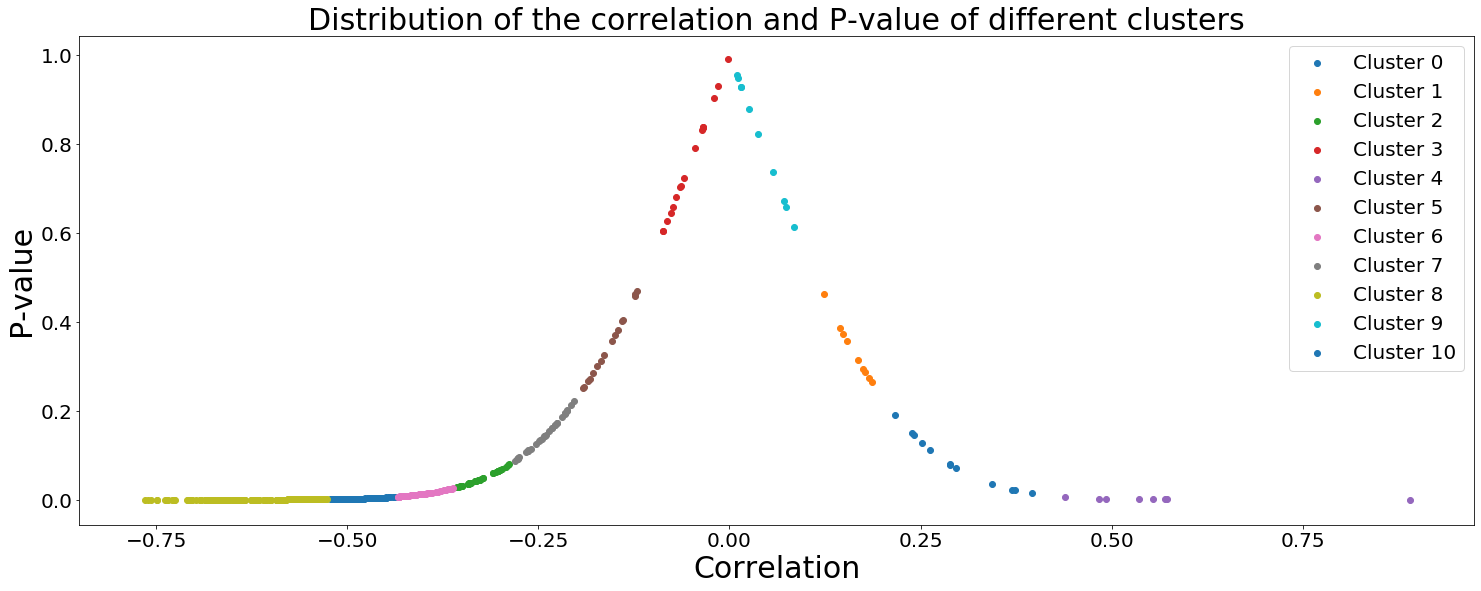

In [9]:
# define the model
model = GaussianMixture(n_components=category_num, random_state = 9)
# fit the model
model.fit(correlation)
# assign a cluster to each example
yhat = model.predict(correlation)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(25,9))
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(correlation[row_ix, 0], correlation[row_ix, 1], label = 'Cluster ' + str(cluster))
    for (key, value) in result.items():
        corre = np.array([value[1], value[2]])
        if corre[0] in list(correlation[row_ix, 0].flatten()) and corre[1] in list(correlation[row_ix, 1].flatten()):
            result[key] = (value[0], value[1], value[2], cluster)
# show the plot
plt.legend(loc = 1, fontsize = 20)
plt.savefig('correlation_cluster.png', format='png', dpi = 500)
plt.title(u"Distribution of the correlation and P-value of different clusters", fontsize = 30)
plt.tick_params(labelsize=20)
plt.xlabel(u"Correlation", fontsize = 30)
plt.ylabel(u"P-value", fontsize = 30)
plt.show()

In [10]:
print(len(result))

cluster_sector_num = []
for cluster in clusters:
    sector_num = {'cluster': cluster, 'total': 0}
    for sec in iter(category):
        sector_num[sec] = 0
    for (key, value) in result.items():
        if (value[3] == cluster):
            sector_num['total'] = sector_num['total'] + 1
            #if value[0].shape[0] > 0:
            sector_num[value[0][0]] = sector_num[value[0][0]] + 1
            #else:
                #sector_num['Unknown'] = sector_num['Unknown'] + 1
    cluster_sector_num.append(sector_num)

499


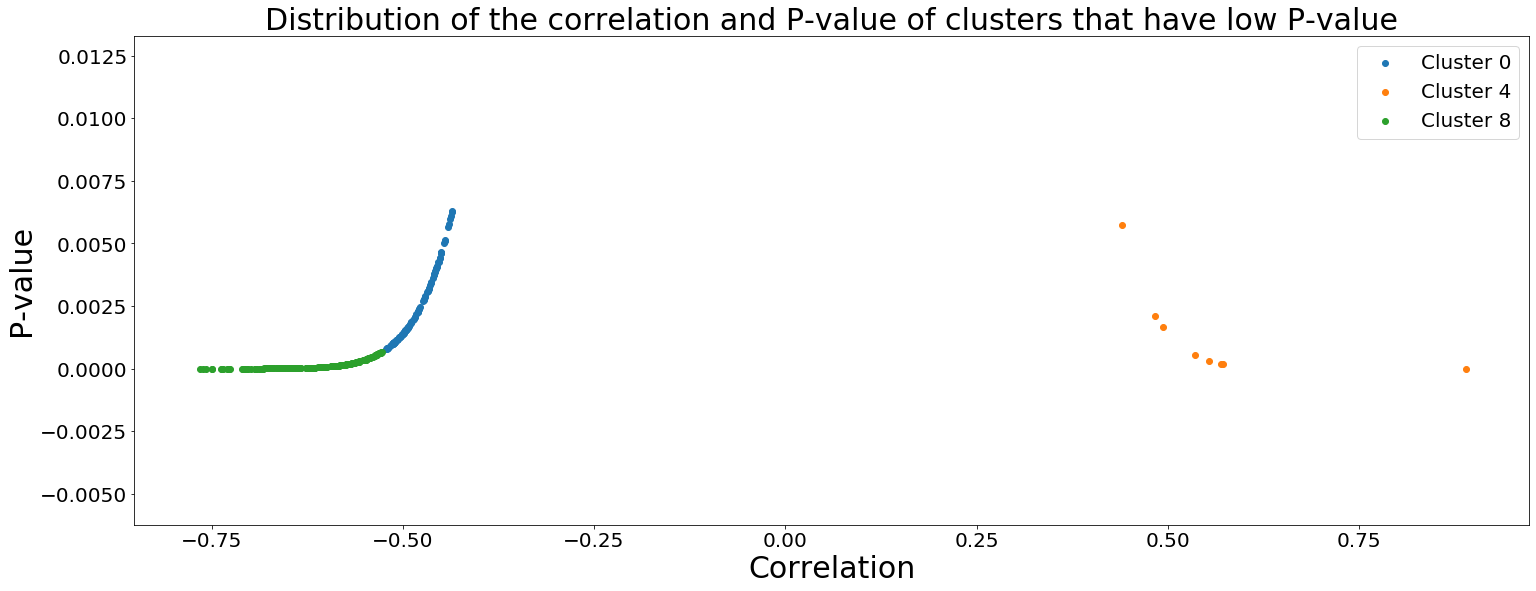

In [11]:
strong_confident = dict()
for (key, value) in result.items():
    if value[2] <= 0.05:
        strong_confident[key] = value
# create scatter plot for samples from each cluster
plt.figure(figsize=(25,9))
cluster_high_corre = []
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    row_ix = np.array(row_ix[0])
    # create scatter of these samples
    new_row_ix = []
    for i in row_ix:
        if correlation[i, 1] <= 0.05 and abs(correlation[i, 0]) >= 0.5:
            new_row_ix.append(i)
    new_row_ix = np.array(new_row_ix)
    if (new_row_ix.shape[0] == 0):
        continue
    plt.scatter(correlation[row_ix, 0], correlation[row_ix, 1], label = 'Cluster ' + str(cluster))
    cluster_high_corre.append(cluster)
# show the plot
plt.legend(loc = 1, fontsize = 20)
plt.savefig('correlation_cluster.png', format='png', dpi = 500)
plt.title(u"Distribution of the correlation and P-value of clusters that have low P-value", fontsize = 30)
plt.tick_params(labelsize=20)
plt.xlabel(u"Correlation", fontsize = 30)
plt.ylabel(u"P-value", fontsize = 30)
plt.show()

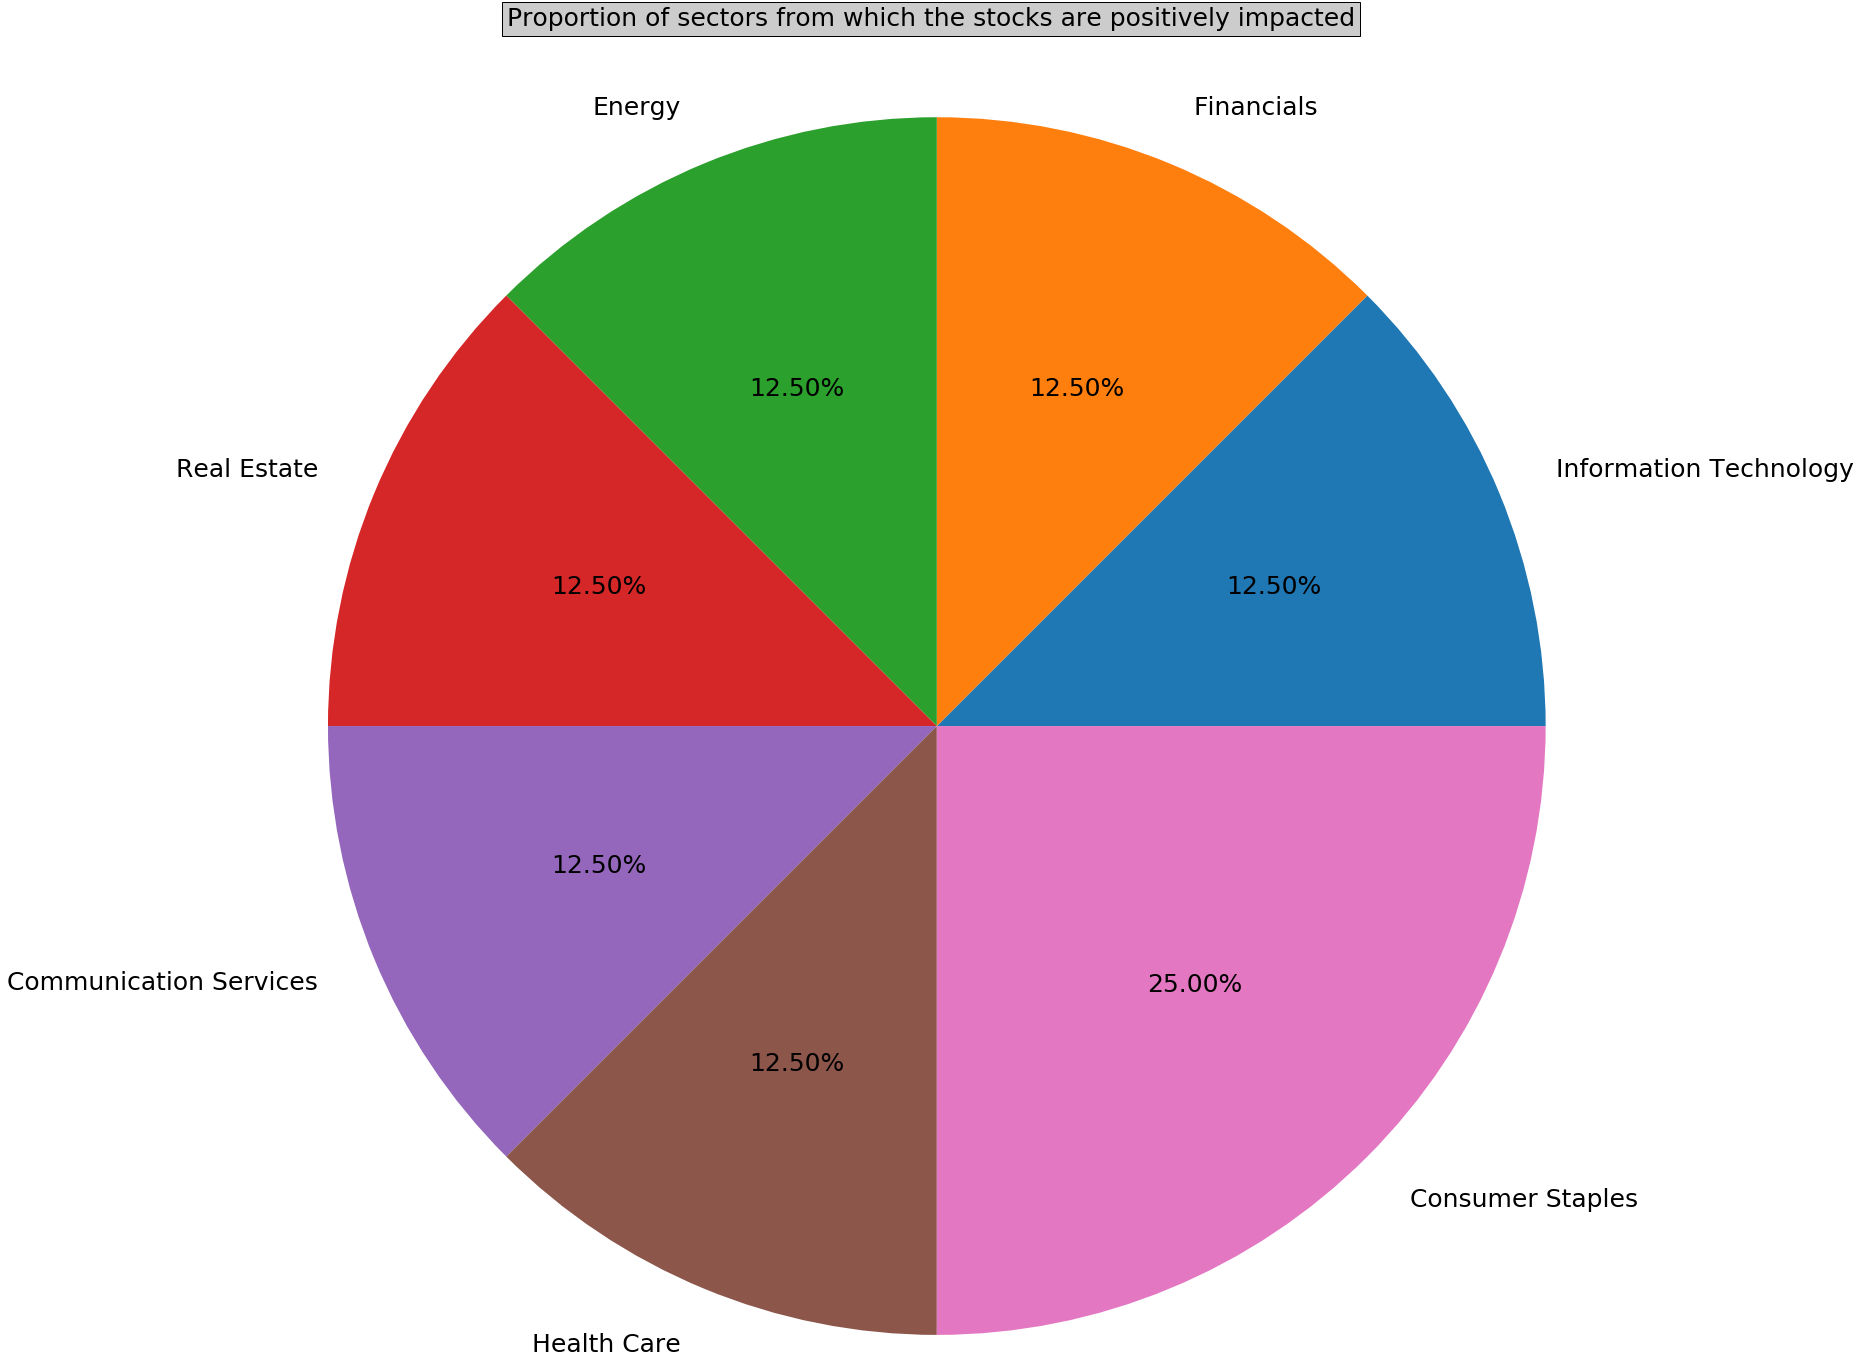

Total number of stocks which are positively impacted: 8



In [20]:

for cluster in cluster_high_corre:
    total = 9999
    for secnum in cluster_sector_num:
        if secnum['cluster'] == cluster:
            label = []
            X = []
            for (key, value) in secnum.items():
                if key == 'total':
                    total = value
                if key != 'cluster' and key != 'total':
                    if (value != 0):
                        label.append(key)
                        X.append(value)
                elif key == 'total':
                    total = value
    #plt.suptitle("Proportion of sectors from which the stocks come - cluster"+str(cluster), bbox={'facecolor':'0.8', 'pad':5}, fontsize=25)
    #plt.show()
    if total <= 20:
        fig = plt.figure()
        #print("Proportion of sectors from which the stocks come - cluster"+str(cluster))
        plt.pie(X,labels=label,autopct='%1.2f%%', radius = 7, textprops={'fontsize': 25}) #画饼图（数据，数据对应的标签，百分数保留两位小数点）
        #plt.suptitle("Proportion of sectors from which the stocks come - cluster"+str(cluster), bbox={'facecolor':'0.8', 'pad':5}, y = 3, fontsize=25)
        plt.suptitle("Proportion of sectors from which the stocks are positively impacted", bbox={'facecolor':'0.8', 'pad':5}, y = 3, fontsize=25)
        plt.show()  
        #print("Stock number of this cluster: %d"%(total))
        print("Total number of stocks which are positively impacted: %d"%(total))
        print()

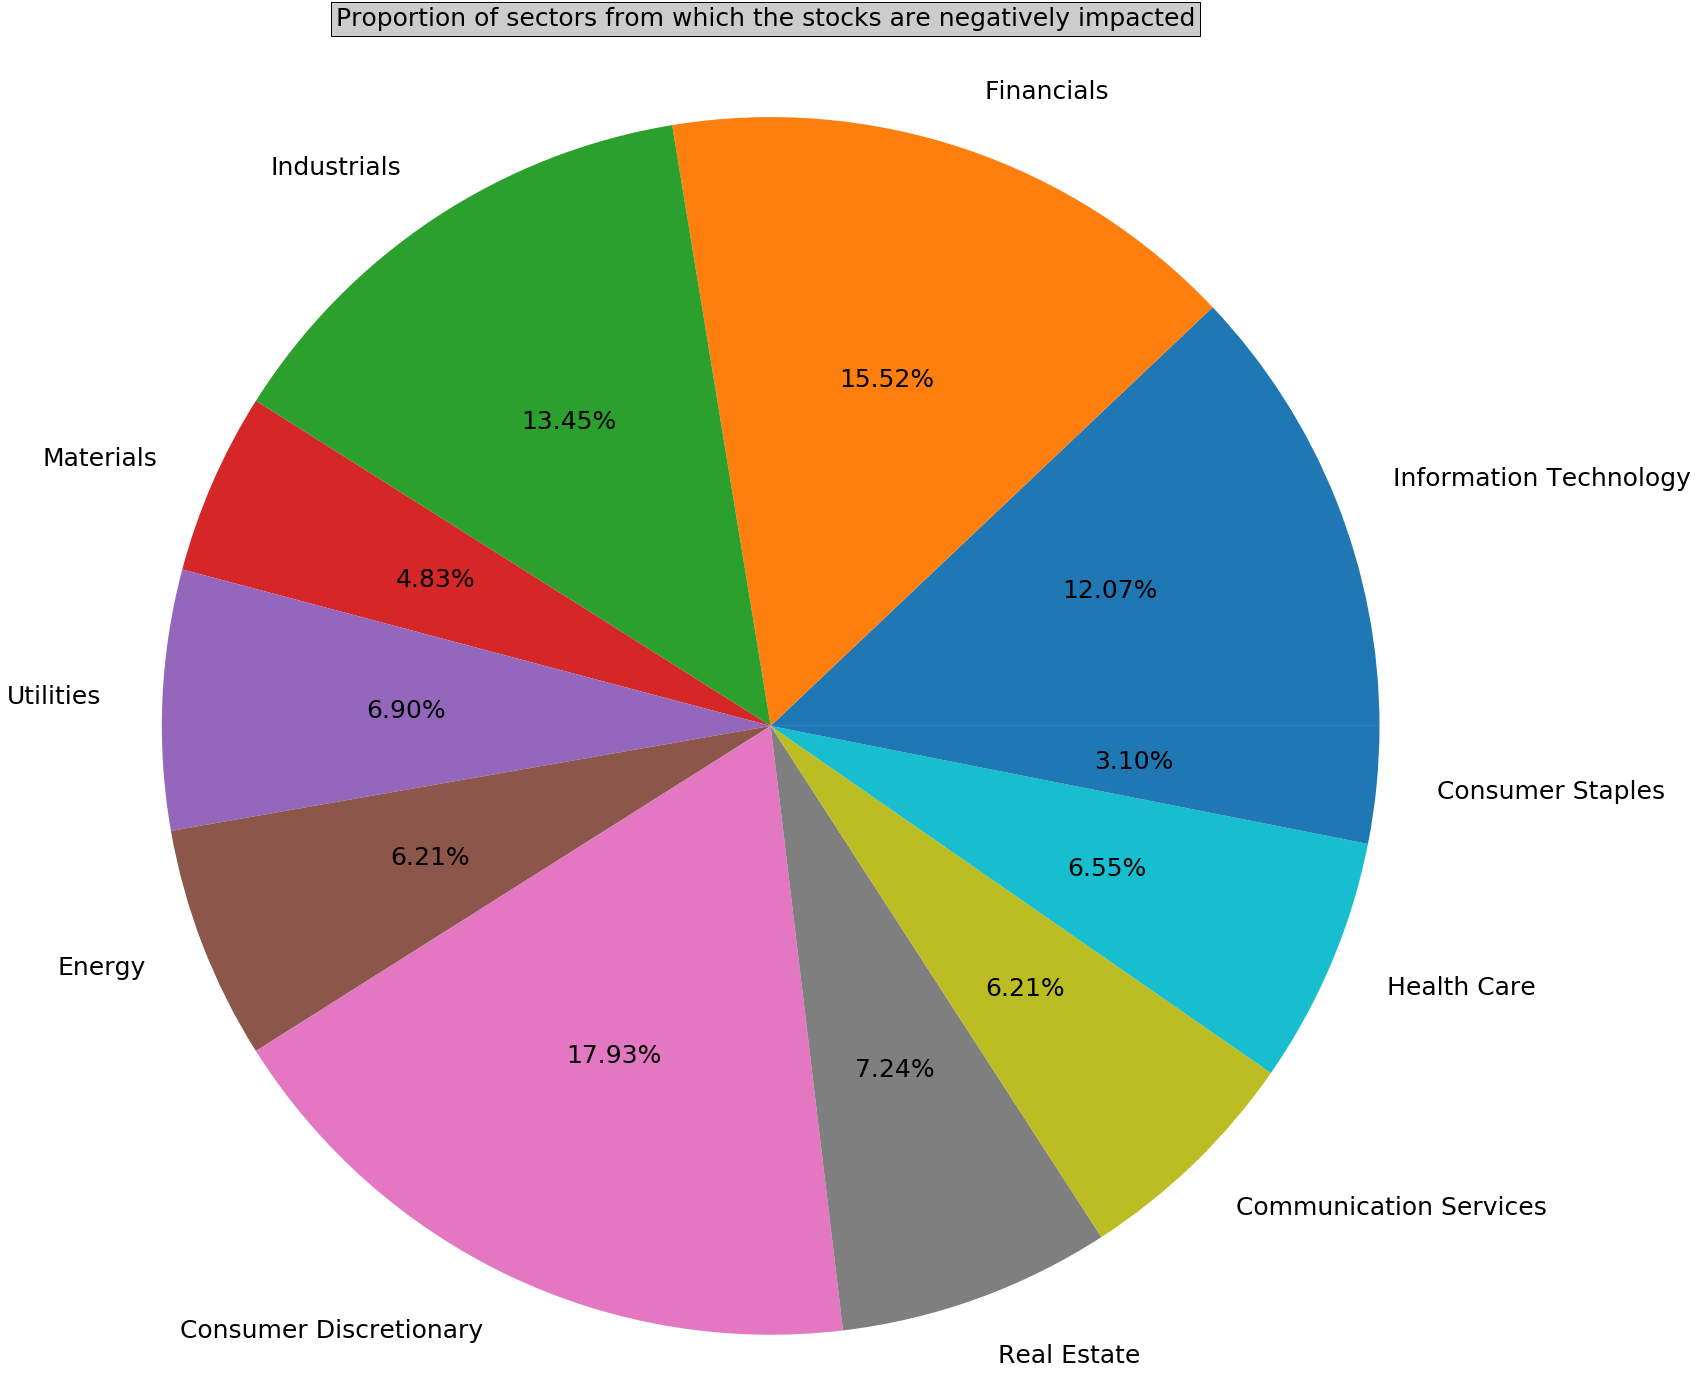

Total number of stocks which are negatively impacted: 290



In [17]:
temp_dic = {}
for cluster in cluster_high_corre:
    for secnum in cluster_sector_num:
        if secnum['cluster'] != cluster:
            continue
        if secnum['total'] <= 20:
            break
        for (key, value) in secnum.items():
            if key == 'total':
                if temp_dic.__contains__('total'):
                    tmp = temp_dic['total']
                    temp_dic['total'] = tmp + value
                else:
                    temp_dic['total'] = value
            if key != 'cluster' and key != 'total':
                if temp_dic.__contains__(key):
                    tmp = temp_dic[key]
                    temp_dic[key] = tmp + value
                else:
                    temp_dic[key] = value

negative_label = []
negative_X = []
total = 0
for (key, value) in temp_dic.items():
    if key == 'total':
        total = value
    else:
        negative_label.append(key)
        negative_X.append(value)
    #plt.suptitle("Proportion of sectors from which the stocks come - cluster"+str(cluster), bbox={'facecolor':'0.8', 'pad':5}, fontsize=25)
    #plt.show()
fig = plt.figure()
#print("Proportion of sectors from which the stocks come - cluster"+str(cluster))
plt.pie(negative_X,labels=negative_label,autopct='%1.2f%%', radius = 7, textprops={'fontsize': 25}) #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.suptitle("Proportion of sectors from which the stocks are negatively impacted", bbox={'facecolor':'0.8', 'pad':5}, y = 3, fontsize=25)
plt.show() 
print("Total number of stocks which are negatively impacted: %d"%(total))
print()

In [30]:
intense_affected = {}
for (key, value) in result.items():
    if value[1] >= 0.5 and value[2] <= 0.05:
        intense_affected[key] = value

print("Tickers significantly positively affected by pandemic:")
print()
posi = []
for (key, value) in intense_affected.items():
    ticker = key
    sector = value[0][0]
    correlation = value[1]
    p_val = value[2]
    posi.append((ticker, sector, correlation, p_val))
    
posi = sorted(posi, key=lambda item:item[2], reverse = True)

for ticker in posi:
    print("Ticker: %s"%(ticker[0]))
    print("Sector: %s"%(ticker[1]))
    print("Correlation: %.5f"%(ticker[2]))
    print("P-value: %.10f"%(ticker[3]))
    print()

Tickers significantly positively affected by pandemic:

Ticker: CTXS
Sector: Information Technology
Correlation: 0.88969
P-value: 0.0000000000

Ticker: COG
Sector: Energy
Correlation: 0.57201
P-value: 0.0001755427

Ticker: REGN
Sector: Health Care
Correlation: 0.57007
P-value: 0.0001867568

Ticker: CAG
Sector: Consumer Staples
Correlation: 0.55386
P-value: 0.0003092933

Ticker: HRL
Sector: Consumer Staples
Correlation: 0.53547
P-value: 0.0005316502



In [15]:
print("")
for (key, value) in result.items():
    if key == 'AAPL':
        print(key)
        print(value)
    elif key == 'MSFT':
        print(key)
        print(value)
    elif key == 'GILD':
        print(key)
        print(value)


AAPL
(array(['Information Technology'], dtype=object), -0.49371457969066235, 0.0016326789834321886, 0)
GILD
(array(['Health Care'], dtype=object), 0.3953357766251411, 0.014025624972013493, 10)
MSFT
(array(['Information Technology'], dtype=object), -0.12312100877528856, 0.4614725366828129, 5)
